In [1]:
!pip install mplfinance ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=58ec0fc9c4bd6faf747a0b30373d0f3e7d50de4d9df661ca481df9bf16be6198
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib.pyplot as plt


In [3]:
import yfinance as yf

# 종목 티커 설정 (예: 애플)
ticker = 'AAPL'

# 데이터 불러오기 (기간 및 텀 설정)
data = yf.Ticker(ticker)
df_origin = data.history(interval='1d', period='6mo', auto_adjust=False)

df_origin

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2024-10-07 00:00:00-04:00,224.500000,225.690002,221.330002,221.690002,221.203156,39505400,0.0,0.0
2024-10-08 00:00:00-04:00,224.300003,225.979996,223.250000,225.770004,225.274200,31855700,0.0,0.0
2024-10-09 00:00:00-04:00,225.229996,229.750000,224.830002,229.539993,229.035919,33591100,0.0,0.0
2024-10-10 00:00:00-04:00,227.779999,229.500000,227.169998,229.039993,228.537018,28183500,0.0,0.0
2024-10-11 00:00:00-04:00,229.300003,229.410004,227.339996,227.550003,227.050293,31759200,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-03-31 00:00:00-04:00,217.009995,225.619995,216.229996,222.130005,222.130005,65299300,0.0,0.0
2025-04-01 00:00:00-04:00,219.809998,223.679993,218.899994,223.190002,223.190002,36412700,0.0,0.0
2025-04-02 00:00:00-04:00,221.320007,225.190002,221.020004,223.889999,223.889999,35905900,0.0,0.0


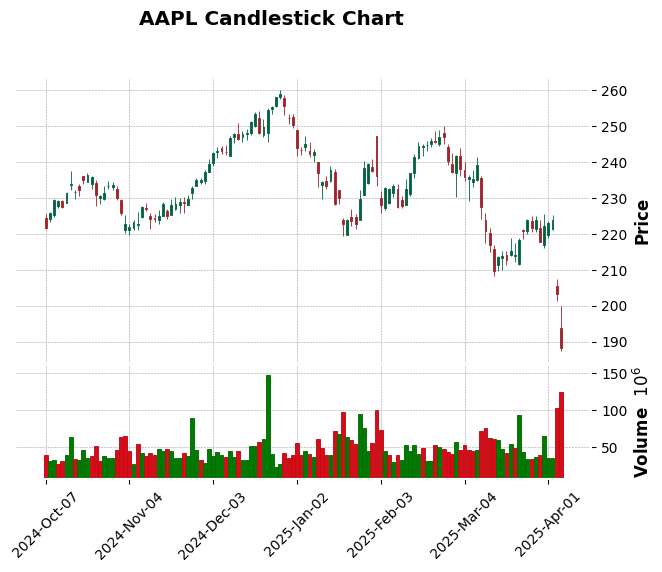

In [4]:
import mplfinance as mpf

# 캔들스틱 차트 그리기 (볼륨 포함)
mpf.plot(df_origin, type='candle', style='charles', title=f"{ticker} Candlestick Chart", volume=True)

In [5]:
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator, EMAIndicator
import pandas as pd

df = pd.DataFrame()

# 2) 기본적인 변화량(시가/고가/저가/종가/거래량)
df['Open_Change']   = df_origin['Open'].diff(1)
df['High_Change']   = df_origin['High'].diff(1)
df['Low_Change']    = df_origin['Low'].diff(1)
df['Close_Change']  = df_origin['Close'].diff(1)
df['Volume_Change'] = df_origin['Volume'].diff(1)

# 3) 20일 지수 이동평균 (EWM20)과 그 변화량
#    ta 라이브러리에도 EMAIndicator가 있지만, pandas ewm()을 직접 써도 무방합니다.
ema20 = EMAIndicator(close=df_origin['Close'], window=20)
df_origin['EWM20'] = ema20.ema_indicator()
df['EWM20_Change'] = df_origin['EWM20'].diff(1)

# 4) KDJ (Fast%K, Slow%D, Slow%J)
#    ta의 StochasticOscillator로 %K, %D를 구한 뒤, J는 3K - 2D 공식을 사용합니다.
stoch = StochasticOscillator(
    high=df_origin['High'],
    low=df_origin['Low'],
    close=df_origin['Close'],
    window=5,         # Fast%K 기간
    smooth_window=3   # Fast%D 기간
)
df['FastK'] = stoch.stoch()          # Fast%K
df['SlowD'] = stoch.stoch_signal()   # Slow%D (StochasticOscillator에서 %K의 이동평균)
df['SlowJ'] = 3 * df['FastK'] - 2 * df['SlowD']  # KDJ의 J 계산

# 5) MACD (MACD, MACDS, MACDO)
macd = MACD(
    close=df_origin['Close'],
    window_slow=26,
    window_fast=12,
    window_sign=9
)
df['MACD']  = macd.macd()
df['MACDS'] = macd.macd_signal()
# 질문에서 MACDO = MACD - MACDS 로 정의했으므로
df['MACDO'] = df['MACD'] - df['MACDS']

# 6) CCI (Commodity Channel Index)
cci = CCIIndicator(
    high=df_origin['High'],
    low=df_origin['Low'],
    close=df_origin['Close'],
    window=14,    # 보통 14 또는 20
    constant=0.015
)
df['CCI'] = cci.cci()

# 7) RSI (Relative Strength Index)
rsi = RSIIndicator(
    close=df_origin['Close'],
    window=14
)
df['RSI'] = rsi.rsi()
df['Close'] = df_origin['Close']

df

# 8) 결과 확인
df.head(10)

,Open_Change,High_Change,Low_Change,Close_Change,Volume_Change,EWM20_Change,FastK,SlowD,SlowJ,MACD,MACDS,MACDO,CCI,RSI,Close
Date,,,,,,,,,,,,,,,
2024-10-07 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.690002
2024-10-08 00:00:00-04:00,-0.199997,0.289993,1.919998,4.080002,-7649700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.770004
2024-10-09 00:00:00-04:00,0.929993,3.770004,1.580002,3.769989,1735400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.539993
2024-10-10 00:00:00-04:00,2.550003,-0.250000,2.339996,-0.500000,-5407600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.039993
2024-10-11 00:00:00-04:00,1.520004,-0.089996,0.169998,-1.489990,3575700.0,NaN,73.871765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.550003
2024-10-14 00:00:00-04:00,-0.600006,2.319992,1.260010,3.750000,8122900.0,NaN,94.929329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.300003
2024-10-15 00:00:00-04:00,4.910004,5.760010,3.769989,2.550003,24869300.0,NaN,71.248038,80.016377,53.711361,NaN,NaN,NaN,NaN,NaN,233.850006
2024-10-16 00:00:00-04:00,-2.009995,-5.370010,-2.529999,-2.070007,-30669200.0,NaN,44.670517,70.282628,-6.553706,NaN,NaN,NaN,NaN,NaN,231.779999
2024-10-17 00:00:00-04:00,1.829987,1.730011,0.680008,0.369995,-1088400.0,NaN,47.389096,54.435884,33.295520,NaN,NaN,NaN,NaN,NaN,232.149994


In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}  # Gym 환경이 지원하는 렌더링 모드 설정 (human 모드는 텍스트 형태로 렌더링).

    # 환경 초기화
    # 클래스 초기화. 매개변수로는 주식 데이터가 담긴 DataFrame(df)을 받음.
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()     # 부모 클래스 (gym.Env) 초기화.

        self.df = df                                # 주가 데이터(DataFrame)를 클래스 내부 변수에 저장.
        self.max_steps = len(df) - 1                # 환경 내 최대 스텝 수를 데이터 길이에 맞춰 설정 (데이터 인덱스를 벗어나지 않기 위해 -1)
        self.current_step = 0                       # 현재 진행 중인 스텝 번호 (에피소드 시작은 항상 0에서부터 시작)
        self.initial_balance = 1000000              # 초기 자산을 100만원으로 설정
        self.balance = self.initial_balance         # 현재 보유 중인 현금을 초기 자산과 동일하게 설정
        self.shares_held = 0                        # 처음에는 주식을 전혀 보유하고 있지 않음
        self.avg_buy_price = 0                      # 평균 매수가격 초기화 (주식을 구매할 때 업데이트됨)

        # 상태 공간 정의 (14개 상태 변수)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(14,), dtype=np.float32)

        # 행동 공간 정의 (0: hold, 1: action)
        self.action_space = spaces.Discrete(2)

    # 다음 상태 가져오기 메서드
    def _next_observation(self):
        obs = self.df.iloc[self.current_step].values.astype(np.float32)   # 현재 스텝에 해당하는 데이터의 지표들을 numpy 배열로 변환하고, float32로 설정
        return obs                                                        # 관측된 상태값 반환

    # 에피소드 초기화
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)                # Gym 환경의 리셋 메서드 호출 (시드값 설정 가능)
        self.balance = self.initial_balance     # 보유 현금을 초기화
        self.shares_held = 0                    # 보유 주식 수 초기화
        self.avg_buy_price = 0                  # 평균 매수가 초기화
        self.current_step = 0                   # 환경의 스텝 번호를 초기화하여 첫 번째 데이터에서 시작
        return self._next_observation(), {}     # 초기 상태를 반환하고, 추가 정보를 담는 dict는 비어있는 상태로 반환

    # 행동 수행 메서드
    def step(self, action):
      done = False                              # 종료 여부를 기본적으로 False로 설정
      self.current_step += 1                    # 스텝을 한 칸 진행시킴 (다음 날로 이동)

      current_price = self.df['Close'].iloc[self.current_step]      # 현재 스텝의 종가를 현재 가격으로 설정
      next_price = self.df['Close'].iloc[self.current_step + 1] if self.current_step + 1 < len(self.df) else current_price

      reward = 0        # 보상을 기본값으로 0으로 설정

      # 현재 현금이 주가보다 많다면 Buy Agent가 행동 결정
      if self.balance >= current_price:
          # Buy agent (0: Buy, 1: Hold)
          if action == 0:  # Buy
              shares_bought = self.balance // current_price   # 살 수 있는 최대 주식 수를 계산 (소수점은 제외)
              self.avg_buy_price = current_price              # 평균 매수가를 현재 가격으로 설정
              self.shares_held += shares_bought               # 보유한 주식 수를 증가
              self.balance -= shares_bought * current_price   # 주식을 사면서 잔고에서 구매한 금액을 차감
              reward = next_price - current_price             # 보상은 내일 가격에서 오늘 가격을 뺀 값으로 설정 (가격이 오르면 양수 보상)

          elif action == 1:  # BuyHold
              reward = (current_price - next_price) / current_price    # 유지 보상은 오늘 가격과 내일 가격의 차이를 비율로 계산

      # 주식을 보유 중이라면 Sell Agent
      elif self.shares_held > 0:
          # Sell agent (0: Sell, 1: Hold)
          if action == 0:  # Sell
              profit = (current_price - self.avg_buy_price) * self.shares_held    # 총 수익을 계산 (현재 가격 - 매수가격) × 보유 주식 수
              reward = profit / self.avg_buy_price                                # 수익을 평균 매수가로 나눠 수익률을 계산하여 보상으로 줌
              self.balance += self.shares_held * current_price                    # 매도한 금액을 현금에 추가
              self.shares_held = 0                                                # 보유 주식 수를 0으로 초기화
              self.avg_buy_price = 0                                              # 평균 매수가도 초기화

          elif action == 1:  # SellHold
              profit = (next_price - self.avg_buy_price) * self.shares_held       # 내일 가격을 바탕으로 예상 수익을 계산
              reward = profit / self.avg_buy_price                                # 예상 수익률을 보상으로 설정

      # 주식도 없고, 현금도 부족하면 행동불가 (reward 0)
      else:
          reward = 0

      # 스텝이 마지막 날에 도달하면 에피소드 종료
      if self.current_step >= self.max_steps - 1:
          done = True

      obs = self._next_observation()  # 새로운 상태 관측값 반환 준비

      return obs, reward, done, False, {} # 다음 상태, 보상, 종료 여부, 그리고 추가 정보(빈 dict)를 반환

    # 렌더링 메서드
    def render(self, mode='human', close=False):
        profit = self.balance + self.shares_held * self.df['Close'].iloc[self.current_step] - self.initial_balance    # 현재 자산과 초기 자산을 비교하여 현재 수익을 계산
        print(f'Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Profit: {profit:.2f}')    # 스텝, 현금 잔고, 보유 주식 수, 누적 수익을 출력하여 현황을 표시


In [7]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = StockTradingEnv(df)

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print()

In [8]:
class DQN(nn.Module):
    def __init__(self, input_dim=15, output_dim=2):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [9]:
# 입력은 14개 상태 변수, 출력은 2개의 행동 (Buy or Hold / Sell or Hold)
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


DQN(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(1000)


In [11]:
BATCH_SIZE = 32
GAMMA = 0.99
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state).to(dtype=torch.float32)  # 명시적으로 float32 지정
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)
    reward_batch = torch.cat(batch.reward).to(dtype=torch.float32)  # 명시적으로 float32 지정

    # 현재 상태의 Q값
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 다음 상태의 가치(DDQN 방식)
    next_state_values = torch.zeros(BATCH_SIZE, device=device, dtype=torch.float32)
    with torch.no_grad():
        next_state_actions = policy_net(non_final_next_states).argmax(1, keepdim=True)
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_state_actions).squeeze(1)

    expected_state_action_values = reward_batch + (GAMMA * next_state_values)

    # 손실 계산
    loss = F.mse_loss(state_action_values.squeeze(), expected_state_action_values)

    # 최적화 단계
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [12]:
num_episodes = 100
TARGET_UPDATE = 4  # target network 업데이트 주기

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        # 행동 선택 (ε-greedy)
        epsilon = 0.1
        if random.random() > epsilon:
            with torch.no_grad():
                action = policy_net(state).argmax().item()
        else:
            action = random.choice([0,1])

        observation, reward, done, _, _ = env.step(action)
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = None

        # Replay buffer에 transition 저장
        memory.push(state, action, reward, next_state)

        state = next_state

        # 모델 최적화
        optimize_model()

        if done:
            break

    # 일정 주기로 target network 업데이트
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f'Episode {episode+1}/{num_episodes} 완료')

print('학습 종료')


Episode 1/100 완료
Episode 2/100 완료
Episode 3/100 완료
Episode 4/100 완료
Episode 5/100 완료
Episode 6/100 완료
Episode 7/100 완료
Episode 8/100 완료
Episode 9/100 완료
Episode 10/100 완료
Episode 11/100 완료
Episode 12/100 완료
Episode 13/100 완료
Episode 14/100 완료
Episode 15/100 완료
Episode 16/100 완료
Episode 17/100 완료
Episode 18/100 완료
Episode 19/100 완료
Episode 20/100 완료
Episode 21/100 완료
Episode 22/100 완료
Episode 23/100 완료
Episode 24/100 완료
Episode 25/100 완료
Episode 26/100 완료
Episode 27/100 완료
Episode 28/100 완료
Episode 29/100 완료
Episode 30/100 완료
Episode 31/100 완료
Episode 32/100 완료
Episode 33/100 완료
Episode 34/100 완료
Episode 35/100 완료
Episode 36/100 완료
Episode 37/100 완료
Episode 38/100 완료
Episode 39/100 완료
Episode 40/100 완료
Episode 41/100 완료
Episode 42/100 완료
Episode 43/100 완료
Episode 44/100 완료
Episode 45/100 완료
Episode 46/100 완료
Episode 47/100 완료
Episode 48/100 완료
Episode 49/100 완료
Episode 50/100 완료
Episode 51/100 완료
Episode 52/100 완료
Episode 53/100 완료
Episode 54/100 완료
Episode 55/100 완료
Episode 56/100 완료
E

최종 자산: 992154.53원
총 수익: -7845.47원


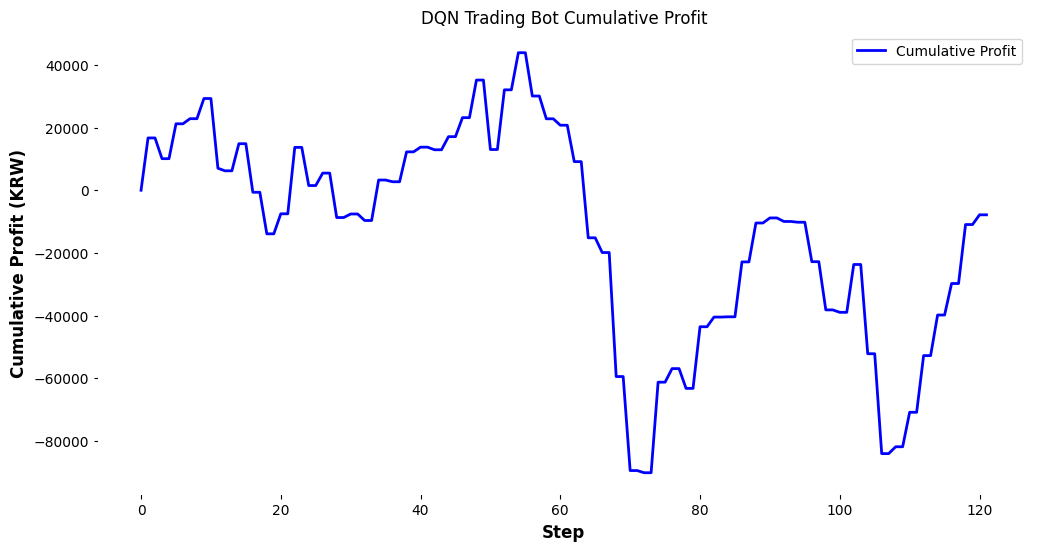

In [13]:
import matplotlib.pyplot as plt

# 평가용 환경 초기화
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

done = False
total_profit = []
balances = []
steps = []

balance = env.initial_balance
shares_held = 0
avg_buy_price = 0

for step in range(env.max_steps):
    with torch.no_grad():
        action = policy_net(state).argmax().item()

    observation, reward, done, _, _ = env.step(action)

    current_price = env.df['Close'].iloc[env.current_step]

    # Buy Agent일 때
    if balance >= current_price:
        if action == 0:  # Buy
            shares_bought = balance // current_price
            avg_buy_price = current_price
            shares_held += shares_bought
            balance -= shares_bought * current_price

    # Sell Agent일 때
    elif shares_held > 0:
        if action == 0:  # Sell
            balance += shares_held * current_price
            shares_held = 0
            avg_buy_price = 0

    total_asset = balance + shares_held * current_price
    profit = total_asset - env.initial_balance

    balances.append(total_asset)
    total_profit.append(profit)
    steps.append(step)

    if not done:
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        break

# 최종 결과 출력
final_balance = balances[-1]
final_profit = total_profit[-1]
print(f"최종 자산: {final_balance:.2f}원")
print(f"총 수익: {final_profit:.2f}원")

# 누적 수익률 시각화
plt.figure(figsize=(12,6))
plt.plot(steps, total_profit, label="Cumulative Profit", color='blue')
plt.xlabel('Step')
plt.ylabel('Cumulative Profit (KRW)')
plt.title('DQN Trading Bot Cumulative Profit')
plt.legend()
plt.grid()
plt.show()
